Last week's [blog post](https://greglandrum.github.io/rdkit-blog/posts/2025-12-07-BRICS-synthons.html) looked at using [BRICS](https://greglandrum.github.io/rdkit-blog/posts/2025-08-15-BRICS-tutorial.html) to build a [synthon search space](https://www.rdkit.org/docs/GettingStartedInPython.html#searching-synthon-spaces). This post builds on that and creates a search space using some combichem reactions from a set published by [Hartenfeller et al](http://pubs.acs.org/doi/abs/10.1021/ci200379p). 


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdSynthonSpaceSearch

import rdkit
print(rdkit.__version__)

2025.09.3


I'm going to use a set of Enamine building blocks that I have on my machine.
I loaded these into a [SubstructLibrary](https://greglandrum.github.io/rdkit-blog/posts/2021-12-20-substructlibrary-search-order.html) to make them fast and easy to search.


In [251]:
from rdkit.Chem import rdSubstructLibrary
import pickle
sslib = pickle.load(open('/scratch/Data/Enamine/real_reagents.sslib.pkl','rb'))


# The first reaction

I'll start with the Pictet-Spengler reaction from the [Hartenfeller paper](http://pubs.acs.org/doi/abs/10.1021/ci200379p). It's the first reaction in the SI for that paper and there's something the name that I really like.

Here's the definition of the reaction from the paper

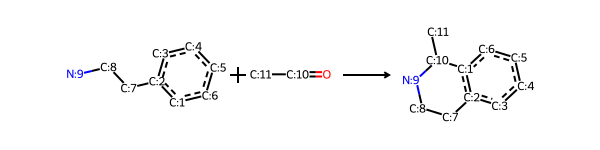

In [207]:
sma = '[cH1:1]1:[c:2](-[CH2:7]-[CH2:8]-[NH2:9]):[c:3]:[c:4]:[c:5]:[c:6]:1.[#6:11]-[CH1;R0:10]=[OD1]>>[c:1]12:[c:2](-[CH2:7]-[CH2:8]-[NH1:9]-[C:10]-2(-[#6:11])):[c:3]:[c:4]:[c:5]:[c:6]:1'

rxn = rdChemReactions.ReactionFromSmarts(sma)
rxn

These are the two prototype educts from the SI:

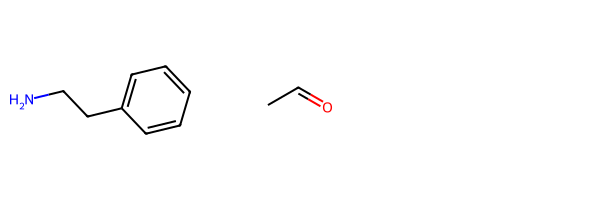

In [208]:
r1 = Chem.MolFromSmiles('c1cc(CCN)ccc1')
r2 = Chem.MolFromSmiles('CC(=O)')
Draw.MolsToGridImage((r1,r2))

To make what's going on in the reaction a bit easier to identify, here I add the atom map numbers from the reaction to the sample educts:

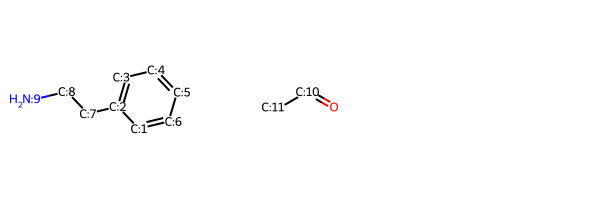

In [209]:
r_queries = [rxn.GetReactantTemplate(x) for x in range(rxn.GetNumReactantTemplates())]

for r,q in zip([r1,r2],r_queries):
    match = r.GetSubstructMatch(q)
    assert match
    for i,midx in enumerate(match):
        mnum = q.GetAtomWithIdx(i).GetAtomMapNum()
        if mnum:
            r.GetAtomWithIdx(midx).SetAtomMapNum(mnum)
Draw.MolsToGridImage((r1,r2))

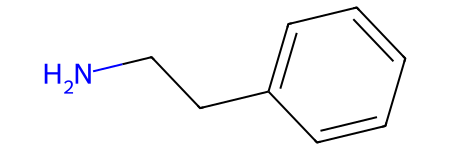

In [206]:
r

I'm going to encode the reaction as three synthons: a core and two "sidechains"

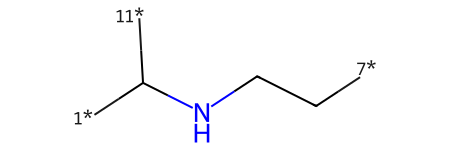

In [195]:
core = Chem.MolFromSmiles('[7*]CCNC([11*])[1*]')
core

Here's what I get for the two sample educts:

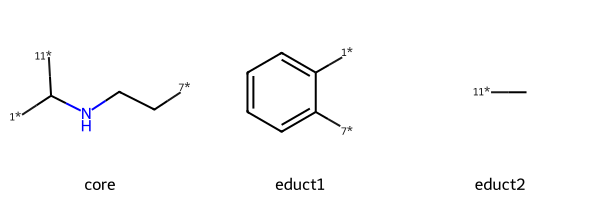

In [196]:
chains = [Chem.MolFromSmiles(x) for x in ('[7*]c1ccccc1[1*]','C[11*]')]
Draw.MolsToGridImage([core,chains[0],chains[1]],legends=['core','educt1','educt2'])

We can put these together using molzip (which is what the sython search code uses) to get the product:

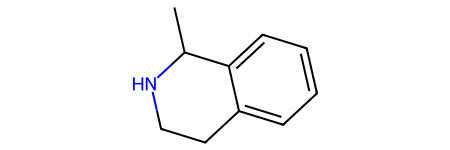

In [197]:
tm = Chem.RWMol(core)
tm.InsertMol(chains[0])
tm.InsertMol(chains[1])

ps = Chem.MolzipParams()
ps.label = Chem.MolzipLabel.Isotope
tm = Chem.molzip(tm,ps)
tm

Now we need reactions that transform the building blocks that you would find in a chemical catalog into the synthons we need for the two educts.

I will do this using reactions.

In [198]:
r1_prep = rdChemReactions.ReactionFromSmarts('[cH1:1]1:[c:2](-[CH2:7]-[CH2:8]-[NH2:9]):[c:3]:[c:4]:[c:5]:[c:6]:1\
>>[1*]-[c:1]1:[c:2](-[7*])[c:3]:[c:4]:[c:5]:[c:6]1')
p = r1_prep.RunReactant(r1,0)

[15:59:19] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 7 8 9 


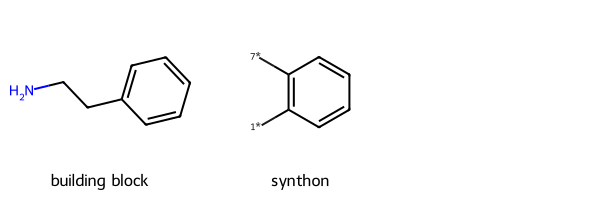

In [199]:
Draw.MolsToGridImage([r1,p[0][0]],legends=['building block','synthon'])

[15:59:41] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 10 


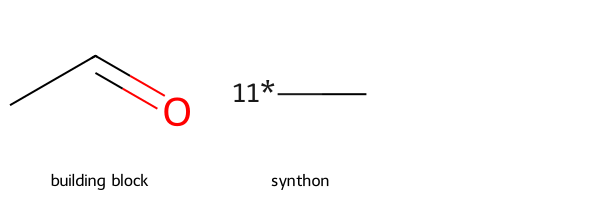

In [200]:
r2_prep = rdChemReactions.ReactionFromSmarts('[#6:11]-[CH1;R0:10]=[OD1]>>[#6:11]-[11*]')
p = r2_prep.RunReactant(r2,0)

Draw.MolsToGridImage([r2,p[0][0]],legends=['building block','synthon'])

More complex reactions (see the next example) may have multiple cores. I want to try and have the code for creating the space be reasonably generic, so I'll put the preparation reactions and core into a list:

In [215]:
r_queries = [rxn.GetReactantTemplate(x) for x in range(rxn.GetNumReactantTemplates())]
possibles = [(core,(r1_prep,r2_prep))]

In [220]:
def enumerate_synthons(possibles,outf,writeHeader=True,startIdx=1,nWritten=1):
    if writeHeader:
        outf.write('\t'.join(['SMILES','synton_id','synton#','reaction_id','release'])+'\n')
    for rxnidx,poss in enumerate(possibles,start=startIdx):
        # get the core and preparation reactions
        core,preps = poss
        # write out the core:
        outf.write(f'{Chem.MolToSmiles(core)}\t{nWritten}\t1\tr{rxnidx}\t1\n')

        # now prepare each of the sidechain synthons:
        nWritten += 1
        for ridx,prep in enumerate(preps):
            if not prep.GetNumProductTemplates():
                continue
            # find possible building blocks that could work here:
            poss = sslib.GetMatches(r_queries[ridx],maxResults=10000)
            print(rxnidx,ridx,len(poss),nWritten)
            seen = set()
            # now loop over those, prepare them, and write them to the output:
            for mol in (sslib.GetMol(x) for x in poss):
                # we use an R0 primitive in the query, so make sure
                # we have ring presence
                Chem.FastFindRings(mol)
                # run our prep reaction:
                ps = prep.RunReactant(mol,0)
                # write each product (in case there's more than one)
                for p in ps:
                    smi= Chem.MolToSmiles(p[0])
                    # don't write duplicates:
                    if smi in seen:
                        continue
                    outf.write(f'{smi}\t{nWritten}\t{ridx+2}\tr{rxnidx}\t1\n')
                    seen.add(smi)
                    nWritten += 1
            print('\t',nWritten)
    return rxnidx+1,nWritten

with open('./space1.txt','w+') as outf:
    nextRxn,nextIdx = enumerate_synthons(possibles,outf)
            
                
!head space1.txt

1 0 264 2
	 333
1 1 4456 333
	 4778
SMILES	synton_id	synton#	reaction_id	release
[1*]C([11*])NCC[7*]	1	1	r1	1
[1*]c1ccccc1[7*]	2	2	r1	1
[1*]c1cc(OC)ccc1[7*]	3	2	r1	1
[1*]c1cc(S(N)(=O)=O)ccc1[7*]	4	2	r1	1
[1*]c1cc(Cl)ccc1[7*]	5	2	r1	1
[1*]c1cc(OC)c(OC)cc1[7*]	6	2	r1	1
[1*]c1c([7*])ccc(OC)c1OC	7	2	r1	1
[1*]c1cc(Cl)cc(Cl)c1[7*]	8	2	r1	1
[1*]c1cc(F)ccc1[7*]	9	2	r1	1


In [213]:
spc = rdSynthonSpaceSearch.SynthonSpace()
spc.ReadTextFile('space1.txt')
spc.GetNumProducts()


1471295

1000 results


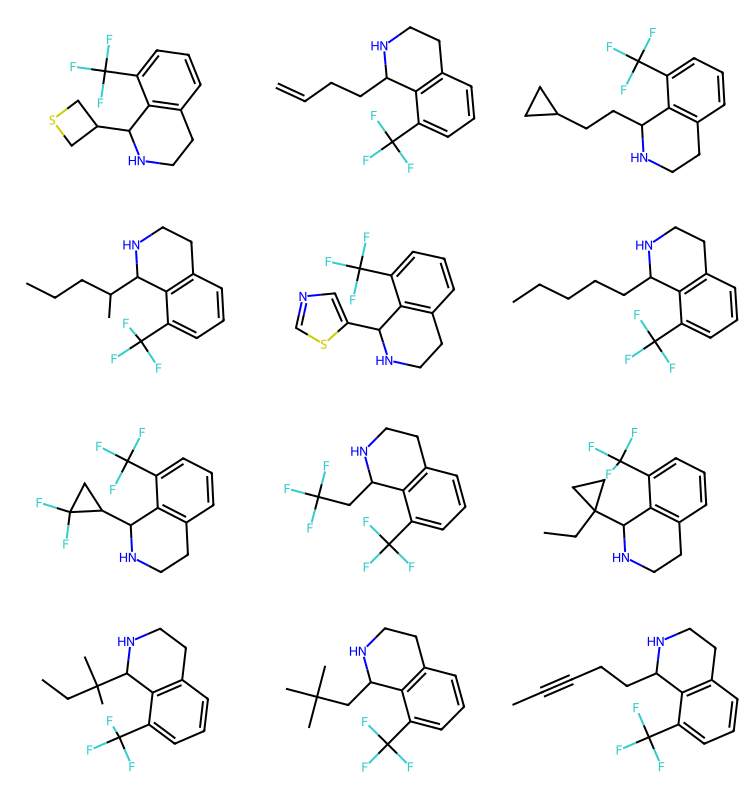

In [214]:
q2 = Chem.MolFromSmarts('')
q1 = Chem.MolFromSmarts('c1cccc(C(F)(F)F)c1C')
#q = Chem.MolFromSmarts('O=c1ncncc1')

params = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
params.randomSample = True
params.randomSeed = 0xf00d

res = spc.SubstructureSearch(q1,params=params)
resMols = list(sorted(res.GetHitMolecules(),key=lambda x:x.GetNumHeavyAtoms()))
# resMols = res.GetHitMolecules()
print(f'{len(resMols)} results')
Draw.MolsToGridImage(resMols[:12],subImgSize=(250,200)) if len(resMols) else None

# Second reaction

The second reaction is `Niementowski_quinazoline`, also from the [Hartenfeller paper](http://pubs.acs.org/doi/abs/10.1021/ci200379p). I've used this reaction before in a [blog post showing how to extract information from reaction products](https://greglandrum.github.io/rdkit-blog/posts/2025-06-12-using-reaction-info.html). 

This one is a bit trickier to encode.

Start with the reaction definition:

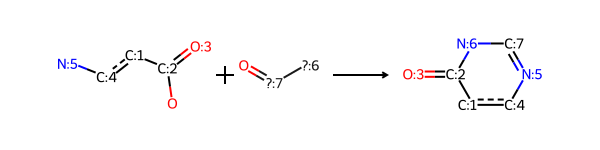

In [252]:
sma = '[c:1](-[C;$(C-c1ccccc1):2](=[OD1:3])-[OH1]):[c:4](-[NH2:5]).[N;!H0;!$(N-N);!$(N-C=N);!$(N(-C=O)-C=O):6]-[C;H1,$(C-[#6]):7]=[OD1]>>[c:4]2:[c:1]-[C:2](=[O:3])-[N:6]-[C:7]=[N:5]-2'

rxn = rdChemReactions.ReactionFromSmarts(sma)
rxn

These are the two educts from the SI:

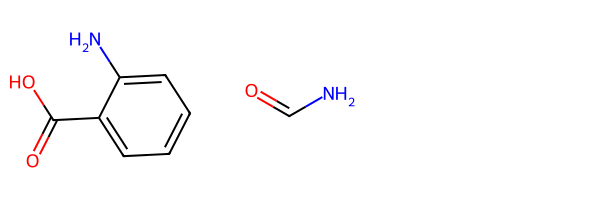

In [253]:
r1 = Chem.MolFromSmiles('c1c(C(=O)O)c(N)ccc1')
r2 = Chem.MolFromSmiles('C(=O)N')
Draw.MolsToGridImage((r1,r2))

Here are the educts with atom map info:

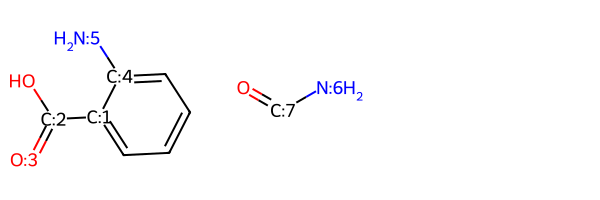

In [254]:
r_queries = [rxn.GetReactantTemplate(x) for x in range(rxn.GetNumReactantTemplates())]

for r,q in zip([r1,r2],r_queries):
    match = r.GetSubstructMatch(q)
    assert match
    for i,midx in enumerate(match):
        mnum = q.GetAtomWithIdx(i).GetAtomMapNum()
        if mnum:
            r.GetAtomWithIdx(midx).SetAtomMapNum(mnum)
Draw.MolsToGridImage((r1,r2))

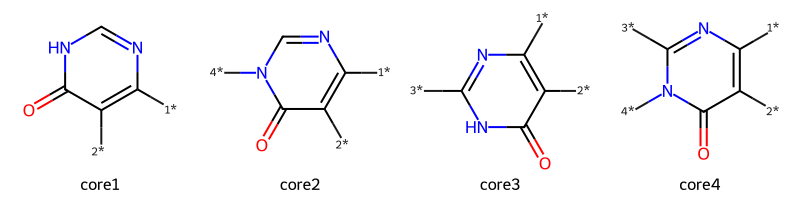

In [288]:
#-----
# Educt 2 is a primary amine
#   core1: no substituent on educt 2 carbon
core1 = Chem.MolFromSmiles('O=C1-N-C=N-C([1*]):C1[2*]',sanitize=True)
#   core3: educt2 has a substituent on the carbon
core3 = Chem.MolFromSmiles('O=C1-N-C([3*])=N-C([1*]):C1[2*]',sanitize=True)

# Educt 2 is a secondary amine
#   core2: no substituent on educt 2 carbon
core2 = Chem.MolFromSmiles('O=C1-N([4*])-C=N-C([1*]):C1[2*]',sanitize=True)
#   core4: educt2 has a substituent on the carbon
core4 = Chem.MolFromSmiles('O=C1-N([4*])-C([3*])=N-C([1*]):C1[2*]',sanitize=True)

Draw.MolsToGridImage([core1,core2,core3,core4],legends=['core1','core2','core3','core4'],molsPerRow=4)

In [257]:
r1_prep = rdChemReactions.ReactionFromSmarts('[c:1]1(-[C:2](=[OD1:3])-[OH1]):[c:4](-[NH2:5])[c:6][c:7][c:8][c:9]1\
>>[2*][c:6][c:7][c:8][c:9][1*]')
p = r1_prep.RunReactant(r1,0)

[05:23:12] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 1 2 3 4 5 


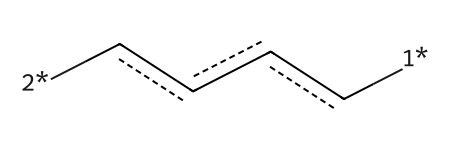

In [258]:
p[0][0]

Make sure we form the correct ring:

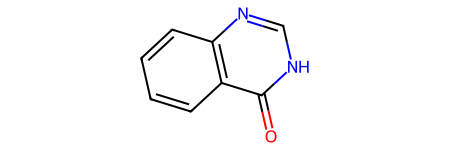

In [227]:
ps = Chem.MolzipParams()
ps.label = Chem.MolzipLabel.Isotope
tm = Chem.molzip(core1,p[0][0],ps)
tm

Now do the preparation reactions for R2, taking the four scenarios into account:

In [294]:
r2_prep1 = rdChemReactions.ReactionFromSmarts('[NH2;!$(N-N);!$(N-C=N);!$(N(-C=O)-C=O):6]-[CH1:7]=[OD1]\
>>')
r2_prep3 = rdChemReactions.ReactionFromSmarts('[NH2;!$(N-N);!$(N-C=N);!$(N(-C=O)-C=O):6]-[C:7](-[#6:3])=[OD1]\
>>[3*][#6:3]')
r2_prep2 = rdChemReactions.ReactionFromSmarts('[*:8][NH1;!$(N-N);!$(N-C=N);!$(N(-C=O)-C=O):6]-[CH1:7]=[OD1]\
>>[4*][*:8]')
r2_prep4 = rdChemReactions.ReactionFromSmarts('[*:8][NH1;!$(N-N);!$(N-C=N);!$(N(-C=O)-C=O):6]-[C;R0:7](-[#6:3])=[OD1]\
>>([4*][*:8].[3*][*:7])')


In [295]:
possibles = [(core1,(r1_prep,r2_prep1)),(core2,(r1_prep,r2_prep2)),
             (core3,(r1_prep,r2_prep3)),(core4,(r1_prep,r2_prep4))]


Create the synthon space:

In [296]:
with open('./space2.txt','w+') as outf:
    nextRxn,nextIdx = enumerate_synthons(possibles,outf)
            
                
!head space2.txt

1 0 189 2
	 188
2 0 189 189
	 375
2 1 8173 375


[05:38:56] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 6 7 


	 383
3 0 189 384
	 570
3 1 8173 570


[05:38:57] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 6 7 


	 1690
4 0 189 1691
	 1877
4 1 8173 1877


[05:38:57] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 6 3 


	 3769
SMILES	synton_id	synton#	reaction_id	release
[1*]c1nc[nH]c(=O)c1[2*]	1	1	r1	1
[1*]ccc1c([2*])C(=O)c2ccccc2C1=O	2	2	r1	1
[1*]cc(Cl)cc([2*])Cl	3	2	r1	1
[1*]ccc(c[2*])C(F)(F)F	4	2	r1	1
[1*]ccc(Cl)c[2*]	5	2	r1	1
[1*]cc1ccccc1c[2*]	6	2	r1	1
[1*]cc(OC)c(c[2*])OC	7	2	r1	1
[1*]cc(cc[2*])S(=O)(=O)Nc1ccccc1OC	8	2	r1	1
[1*]cc(cc[2*])S(=O)(=O)Nc1ccc(OC)cc1	9	2	r1	1


Read it in

In [297]:
spc = rdSynthonSpaceSearch.SynthonSpace()
spc.ReadTextFile('space2.txt')
spc.GetNumProducts()

561906

Search

1000 results


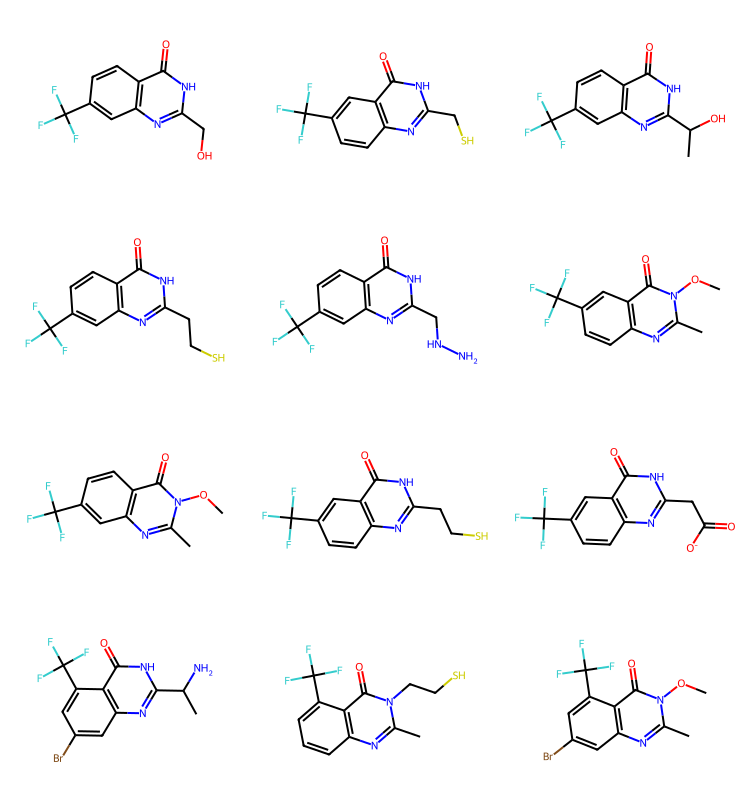

In [286]:
q2 = Chem.MolFromSmarts('cC(F)(F)F')
params = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
params.randomSample = True
params.randomSeed = 0xf00d

res = spc.SubstructureSearch(q2,params=params)
resMols = list(sorted(res.GetHitMolecules(),key=lambda x:x.GetNumHeavyAtoms()))
# resMols = res.GetHitMolecules()
print(f'{len(resMols)} results')
Draw.MolsToGridImage(resMols[:12],subImgSize=(250,200)) if len(resMols) else None

We have results here for cores 2-4, but none for core 1. Let's confirm that there are core1 results in the set

[05:41:48] Complex queries can be slow.


186 results


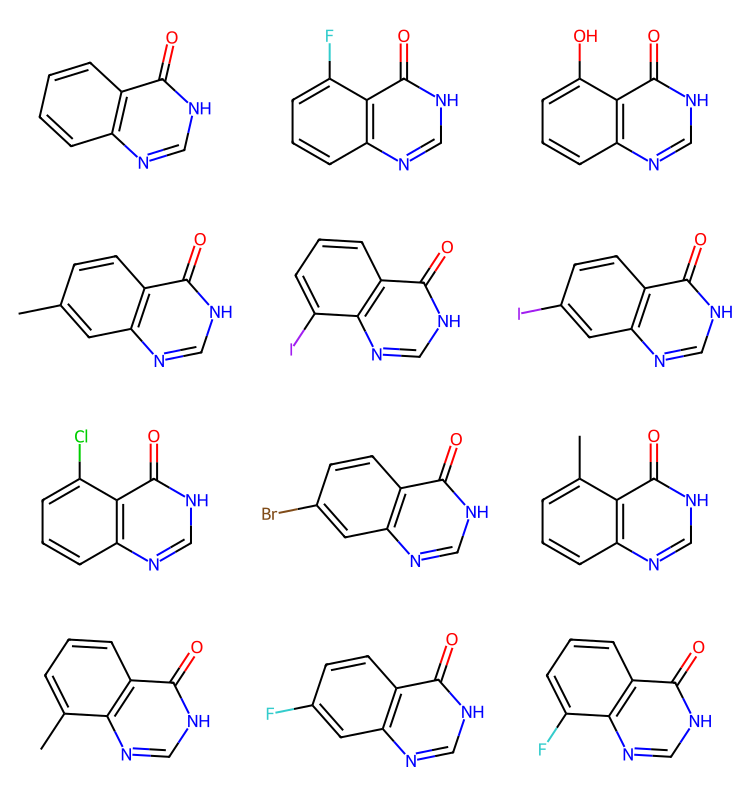

In [298]:
q2 = Chem.MolFromSmarts('[#6](=O)@[#7H1]@[#6H1]@[#7]')
params = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
params.randomSample = True
params.randomSeed = 0xf00d

res = spc.SubstructureSearch(q2,params=params)
resMols = list(sorted(res.GetHitMolecules(),key=lambda x:x.GetNumHeavyAtoms()))
# resMols = res.GetHitMolecules()
print(f'{len(resMols)} results')
Draw.MolsToGridImage(resMols[:12],subImgSize=(250,200)) if len(resMols) else None

# Combine the two reaction spaces

We now add these synthons to the other space. We could do this by sequentially enumerating the spaces into the same output file, but it's quicker to re-enumerate the second space onto the bottom of the output file from the first one:

In [289]:
!cp space1.txt combined.txt
!tail combined.txt

[11*]c1ccnn1-c1cccnc1	4768	3	r1	1
[11*]C1CC2(C1)CC(OC)C2	4769	3	r1	1
[11*]c1c(Cl)cnc(F)c1Cl	4770	3	r1	1
[11*]c1cc(Cl)c(C(=O)O)s1	4771	3	r1	1
[11*]C1COC2CC1C2	4772	3	r1	1
[11*]C12C3CCC(CC31)C2(F)F	4773	3	r1	1
[11*]c1ccc(C(F)(F)C(F)(F)F)s1	4774	3	r1	1
[11*]C12C3CC(CC31)C2NC(=O)OC(C)(C)C	4775	3	r1	1
[11*]C1OCCOC1(C)C	4776	3	r1	1
[11*]c1cc(C)cc(C(F)F)c1	4777	3	r1	1


Now re-enumerate the second space, start the synthon IDs at 4778 and the reaction IDs at 2:

In [299]:
with open('combined.txt','a') as outf:
    enumerate_synthons(possibles,outf,writeHeader=False,nWritten=4778,startIdx=2)
spc = rdSynthonSpaceSearch.SynthonSpace()
spc.ReadTextFile('combined.txt')
spc.GetNumProducts()

2 0 189 4779
	 4965
3 0 189 4966
	 5152
3 1 8173 5152
	 5160
4 0 189 5161
	 5347
4 1 8173 5347
	 6467
5 0 189 6468
	 6654
5 1 8173 6654
	 8546


5965799

In [300]:
!tail combined.txt

[3*]C.[4*]CC1(N)CCC1	8536	3	r5	1
[3*]C.[4*]C1CCCCC1CN	8537	3	r5	1
[3*]C.[4*]CC1(N)CCCCC1	8538	3	r5	1
[3*]C.[4*]CC1(N)CCCC1	8539	3	r5	1
[3*]C.[4*]C1CC(N)C12CCC2	8540	3	r5	1
[3*]C.[4*]C1CCOCC1N	8541	3	r5	1
[3*]C.[4*]CC(N)c1ccccc1OC	8542	3	r5	1
[3*]C.[4*]C(CN)C(C)(C)C	8543	3	r5	1
[3*]C.[4*]C1Cc2ccccc2C1N	8544	3	r5	1
[3*]C.[4*]C1CC2(C1)CC(N)C2	8545	3	r5	1


Verify that searches return results from both spaces:

1000 results


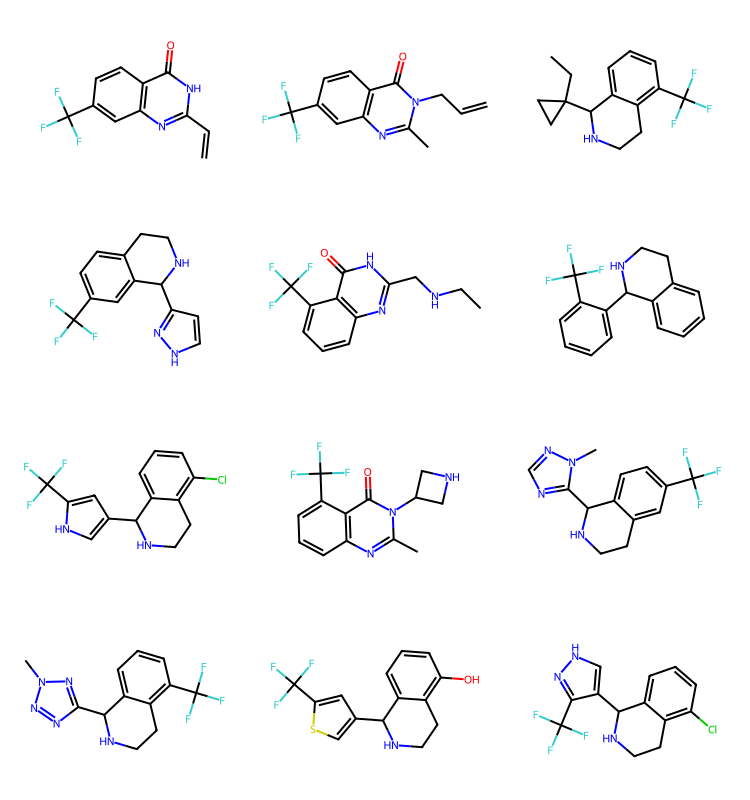

In [301]:
q2 = Chem.MolFromSmarts('cC(F)(F)F')
params = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
params.randomSample = True
params.randomSeed = 0xf00d

res = spc.SubstructureSearch(q2,params=params)
resMols = list(sorted(res.GetHitMolecules(),key=lambda x:x.GetNumHeavyAtoms()))
# resMols = res.GetHitMolecules()
print(f'{len(resMols)} results')
Draw.MolsToGridImage(resMols[:12],subImgSize=(250,200)) if len(resMols) else None

# Reaction 3

For the last example, I'll add the reaction definition for spiro chromanone from the Hartenfeller paper. This one is fun because it forms a spiro linkage.

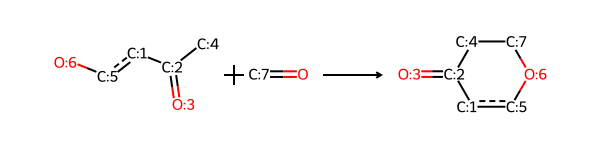

In [302]:
sma = '[c:1](-[C;$(C-c1ccccc1):2](=[OD1:3])-[CH3:4]):[c:5](-[OH1:6]).[C;$(C1-[CH2]-[CH2]-[N,C]-[CH2]-[CH2]-1):7](=[OD1])>>[O:6]1-[c:5]:[c:1]-[C:2](=[OD1:3])-[C:4]-[C:7]-1'

rxn = rdChemReactions.ReactionFromSmarts(sma)
rxn

These are the two educts from the SI:

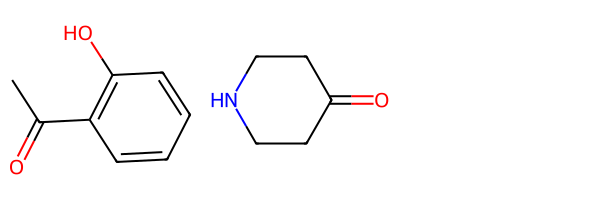

In [303]:
r1 = Chem.MolFromSmiles('c1cc(C(=O)C)c(O)cc1')
r2 = Chem.MolFromSmiles('C1(=O)CCNCC1')
Draw.MolsToGridImage((r1,r2))

Here's what the prototype product looks like:

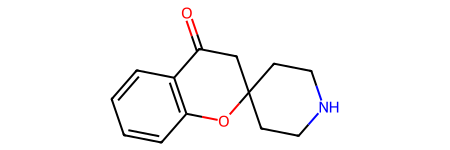

In [304]:
p = rxn.RunReactants([r1,r2])
p[0][0]

Here are the educts with atom map info:

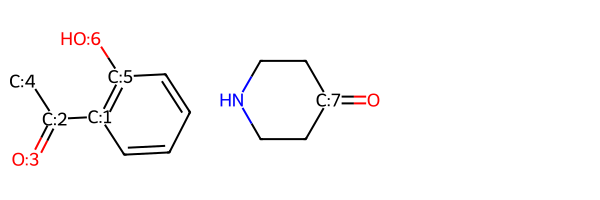

In [305]:
r_queries = [rxn.GetReactantTemplate(x) for x in range(rxn.GetNumReactantTemplates())]

for r,q in zip([r1,r2],r_queries):
    match = r.GetSubstructMatch(q)
    assert match
    for i,midx in enumerate(match):
        mnum = q.GetAtomWithIdx(i).GetAtomMapNum()
        if mnum:
            r.GetAtomWithIdx(midx).SetAtomMapNum(mnum)
Draw.MolsToGridImage((r1,r2))

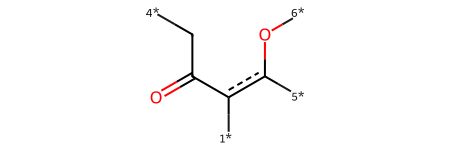

In [309]:
core = Chem.MolFromSmiles('O=C(-[C][4*])c([1*]):c([5*])[O][6*]',sanitize=False)
core

[06:13:20] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 1 2 3 4 5 6 


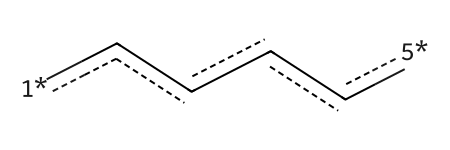

In [317]:
r1_prep = rdChemReactions.ReactionFromSmarts('[c:1]1(-[C:2](=[OD1:3])-[CH3:4]):[c:5](-[OH1:6]):[c:7]:[c:8]:[c:9]:[c:10]1\
>>[*1]:[c:7]:[c:8]:[c:9]:[c:10]:[5*]')
p1 = r1_prep.RunReactant(r1,0)
p1[0][0]

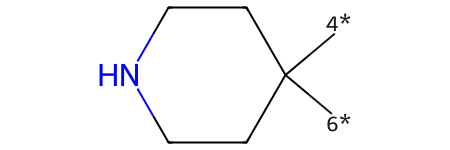

In [318]:
'[C;$(C1-[CH2]-[CH2]-[N,C]-[CH2]-[CH2]-1):7](=[OD1])'
r2_prep = rdChemReactions.ReactionFromSmarts('O=[C:11]1-[CH2:12]-[CH2:13]-[N,C:14]-[CH2:15]-[CH2:16]-1\
>>[4*][C:11]1([6*])-[CH2:12]-[CH2:13]-[N,C:14]-[CH2:15]-[CH2:16]-1')
p2 = r2_prep.RunReactant(r2,0)
p2[0][0]

Make sure we form the correct ring:

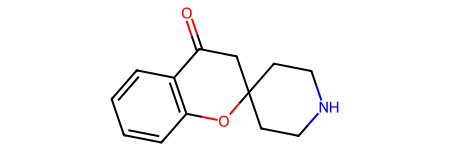

In [321]:
tm = Chem.RWMol(core)
tm.InsertMol(p1[0][0])
tm.InsertMol(p2[0][0])
ps = Chem.MolzipParams()
ps.label = Chem.MolzipLabel.Isotope
tm = Chem.molzip(tm,ps)
tm

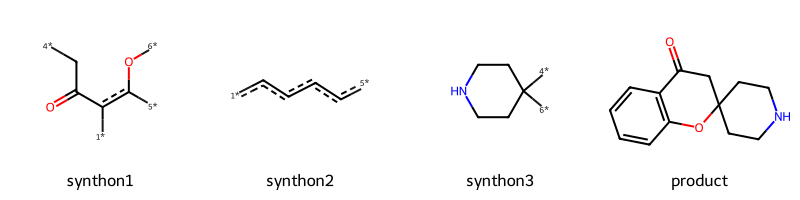

In [334]:
Draw.MolsToGridImage([core,p1[0][0],p2[0][0],tm],legends=['synthon1','synthon2','synthon3','product'],molsPerRow=4)

In [322]:
possibles = [(core,(r1_prep,r2_prep))]


Create the synthon space:

In [323]:
with open('./space3.txt','w+') as outf:
    nextRxn,nextIdx = enumerate_synthons(possibles,outf)
            
                
!head space2.txt

1 0 58 2
	 60
1 1 241 60
	 301
SMILES	synton_id	synton#	reaction_id	release
[1*]c1nc[nH]c(=O)c1[2*]	1	1	r1	1
[1*]ccc1c([2*])C(=O)c2ccccc2C1=O	2	2	r1	1
[1*]cc(Cl)cc([2*])Cl	3	2	r1	1
[1*]ccc(c[2*])C(F)(F)F	4	2	r1	1
[1*]ccc(Cl)c[2*]	5	2	r1	1
[1*]cc1ccccc1c[2*]	6	2	r1	1
[1*]cc(OC)c(c[2*])OC	7	2	r1	1
[1*]cc(cc[2*])S(=O)(=O)Nc1ccccc1OC	8	2	r1	1
[1*]cc(cc[2*])S(=O)(=O)Nc1ccc(OC)cc1	9	2	r1	1


Read it in

In [324]:
spc = rdSynthonSpaceSearch.SynthonSpace()
spc.ReadTextFile('space3.txt')
spc.GetNumProducts()

13978

Search

778 results


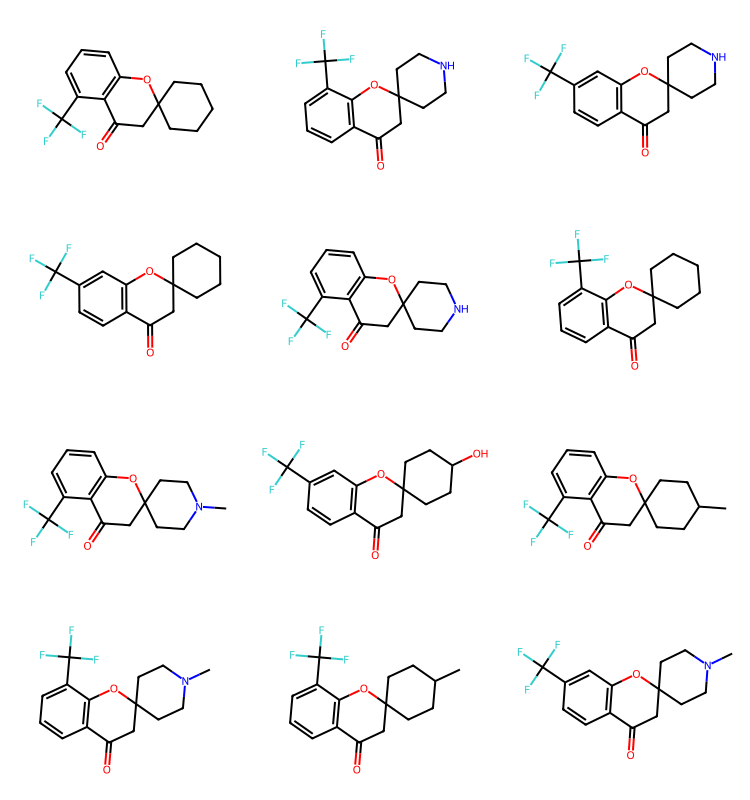

In [325]:
q2 = Chem.MolFromSmarts('cC(F)(F)F')
params = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
params.randomSample = True
params.randomSeed = 0xf00d

res = spc.SubstructureSearch(q2,params=params)
resMols = list(sorted(res.GetHitMolecules(),key=lambda x:x.GetNumHeavyAtoms()))
# resMols = res.GetHitMolecules()
print(f'{len(resMols)} results')
Draw.MolsToGridImage(resMols[:12],subImgSize=(250,200)) if len(resMols) else None

And combine it with the other two:

In [326]:
!tail combined.txt

[3*]C.[4*]CC1(N)CCC1	8536	3	r5	1
[3*]C.[4*]C1CCCCC1CN	8537	3	r5	1
[3*]C.[4*]CC1(N)CCCCC1	8538	3	r5	1
[3*]C.[4*]CC1(N)CCCC1	8539	3	r5	1
[3*]C.[4*]C1CC(N)C12CCC2	8540	3	r5	1
[3*]C.[4*]C1CCOCC1N	8541	3	r5	1
[3*]C.[4*]CC(N)c1ccccc1OC	8542	3	r5	1
[3*]C.[4*]C(CN)C(C)(C)C	8543	3	r5	1
[3*]C.[4*]C1Cc2ccccc2C1N	8544	3	r5	1
[3*]C.[4*]C1CC2(C1)CC(N)C2	8545	3	r5	1


In [328]:
with open('combined.txt','a') as outf:
    enumerate_synthons(possibles,outf,writeHeader=False,nWritten=8546,startIdx=6)
spc = rdSynthonSpaceSearch.SynthonSpace()
spc.ReadTextFile('combined.txt')
print(spc.GetNumProducts())

!tail combined.txt

6 0 58 8547
	 8605
6 1 241 8605
	 8846
6077623
[4*]C1([6*])CCC(=C(F)F)CC1	8836	3	r6	1
[4*]C1([6*])CCN(S(=O)(=O)F)CC1	8837	3	r6	1
[4*]C1([6*])CCN(c2cc(=O)[nH]cn2)CC1	8838	3	r6	1
[4*]C1([6*])CCN(OCc2ccc(Cl)cc2)CC1	8839	3	r6	1
[4*]C1([6*])CCC(N2CCCC2)CC1	8840	3	r6	1
[4*]C1([6*])CCC(N2CCOCC2)CC1	8841	3	r6	1
[4*]C1([6*])CCN(c2cc[nH]c(=O)c2)CC1	8842	3	r6	1
[4*]C1([6*])CCC([N+](=O)[O-])CC1	8843	3	r6	1
[4*]C1([6*])CCC2(CC1)CC2C(=O)OC	8844	3	r6	1
[4*]C1([6*])CCC2(CCC(CBr)O2)CC1	8845	3	r6	1


Do a search to be sure we get results from multiple reactions:

1000 results


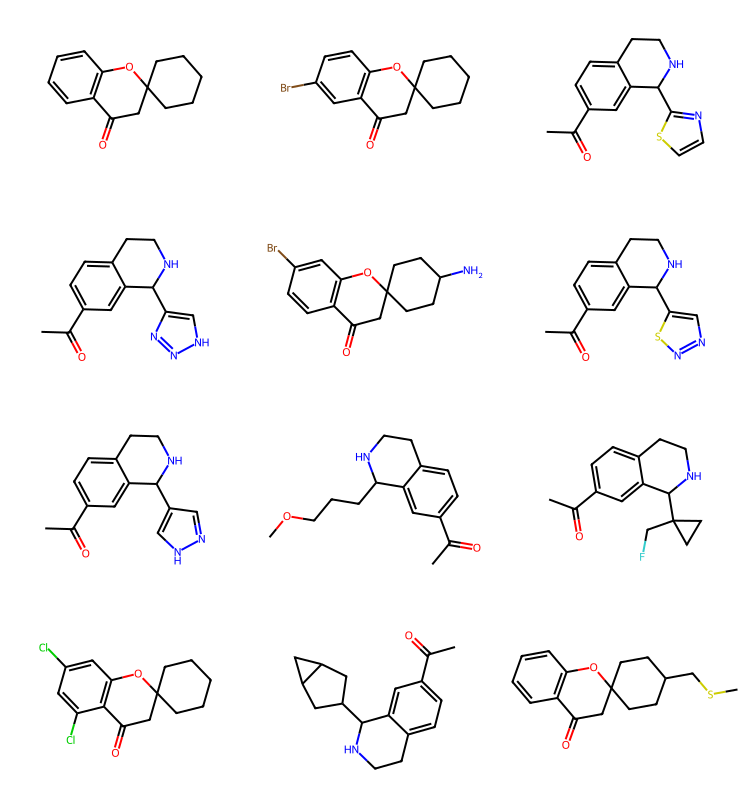

In [332]:
q2 = Chem.MolFromSmarts('cC(=O)C')
params = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
params.randomSample = True
params.randomSeed = 0xf00d

res = spc.SubstructureSearch(q2,params=params)
resMols = list(sorted(res.GetHitMolecules(),key=lambda x:x.GetNumHeavyAtoms()))
# resMols = res.GetHitMolecules()
print(f'{len(resMols)} results')
Draw.MolsToGridImage(resMols[:12],subImgSize=(250,200)) if len(resMols) else None

There are many more reactions in the Hartenfeller paper, but I'm going to stop here.